In [4]:
import pandas as pd 
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df = pd.read_csv('../datasets/isic_combined.csv')

img_dir_path = '../datasets/ISIC_2019_cleaned/'

In [ ]:
features = []

for i, row in df.iterrows():
    image_path = img_dir_path + row['image'] + '.jpg'  
    image = cv2.imread(image_path)
    
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 1: Perform segmentation using Otsu thresholding, as our images are relatively clean. 
    # Otsu thresholding seems to perform well on images with a single subject that is relatively clear from the bg. 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("No contours found for image:", row['image'])
        continue

    # Find the largest contour, assuming it is the skin lesion
    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)

    # Step 2: Calculate HSV Features. We want the following features: 
    # 1. Mean HSV values of the lesion area 
    # 2. The standard deviation of the HSV values of the lesion area
    # 3. The entropy of the HSV histogram of the lesion area

    hsv_pixels = img_hsv[mask == 255]
    hsv_mean = np.mean(hsv_pixels, axis=0)
    hsv_std = np.std(hsv_pixels, axis=0)
    hsv_entropy = hsv_entropy = -np.sum([
        np.histogram(hsv_pixels[:, i], bins=32, range=(0, 256), density=True)[0] * 
        np.log2(np.histogram(hsv_pixels[:, i], bins=32, range=(0, 256), density=True)[0] + 1e-8)
        for i in range(3)
    ])


    # Step 3: Calculate "circularity" of the lesion area 
    # 1. We can use circularity = 4 * pi * area / perimeter^2
    # 2. We can understand eccentricity of the lesion area
    # 3. Convexity of the lesion area: Convex Hull Perimeter / Perimeter
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    ellipse = cv2.fitEllipse(largest_contour) if len(largest_contour) >= 5 else None
    eccentricity = 0
    if ellipse:
        (center, axes, angle) = ellipse
        major, minor = max(axes), min(axes)
        eccentricity = np.sqrt(1 - (minor / major) ** 2)

    convex_hull = cv2.convexHull(largest_contour)
    convexity = cv2.arcLength(convex_hull, True) / perimeter




    # Step 4: Calculate contrast features. How different is the lesion from the skin directly surrounding the lesion?
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    surrounding_mask = cv2.bitwise_and(dilated_mask, cv2.bitwise_not(mask), mask=cv2.bitwise_not(dilated_mask))
    surrounding_hsv = img_hsv[surrounding_mask == 255]

    if len(surrounding_hsv) > 0:
        surrounding_hsv_mean = np.mean(surrounding_hsv, axis=0)
        contrast_hsv = np.abs(hsv_mean - surrounding_hsv_mean)
        contrast_hsv_euclidean = np.linalg.norm(contrast_hsv)
    else:
        contrast_hsv = np.array([0, 0, 0])
        contrast_hsv_euclidean = 0
    

    features.append({
        'image': row['image'],
        'category': row['category'],
        'hsv_mean': hsv_mean,
        'hsv_std': hsv_std,
        'hsv_entropy': hsv_entropy,
        'circularity': circularity,
        'eccentricity': eccentricity,
        'convexity': convexity,
        'contrast_hsv': contrast_hsv,
        'contrast_hsv_euclidean': contrast_hsv_euclidean
    })




,image,category
0,ISIC_0000002,MEL
1,ISIC_0000004,MEL
2,ISIC_0000013,MEL
3,ISIC_0000022_downsampled,MEL
4,ISIC_0000026_downsampled,MEL
...,...,...
41088,ISIC_0034519,validation_weight
41089,ISIC_0034520,validation_weight
41090,ISIC_0034521,validation_weight
41091,ISIC_0034522,validation_weight


Contours found: 2


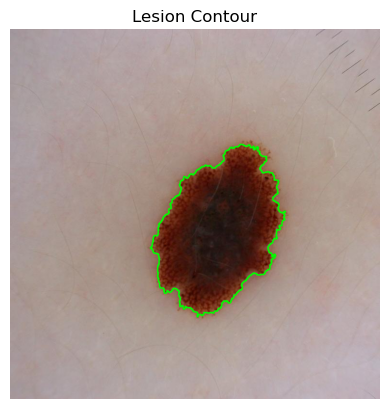

In [18]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Optional: Invert if background is white
if np.sum(thresh == 255) > np.sum(thresh == 0):
    thresh = cv2.bitwise_not(thresh)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Contours found: {len(contours)}")
if contours:
    contour = max(contours, key=cv2.contourArea)

    # Draw contour
    output = image_rgb.copy()
    cv2.drawContours(output, [contour], -1, (0, 255, 0), 2)

    plt.imshow(output)
    plt.title("Lesion Contour")
    plt.axis('off')
    plt.show()
else:
    print("No contours found.")


In [142]:
image_path = '../datasets/ISIC_2019_cleaned/ISIC_0000129_downsampled_preprocessed_rot0.jpg'
image = cv2.imread(image_path)

img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Step 1: Perform segmentation using Otsu thresholding, as our images are relatively clean. 
# Otsu thresholding seems to perform well on images with a single subject that is relatively clear from the bg. 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


if np.sum(thresh == 255) > np.sum(thresh == 0):
    thresh = cv2.bitwise_not(thresh)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) == 0:
    print("No contours found for image:", row['image'])
    
largest_contour = max(contours, key=cv2.contourArea)

mask = np.zeros_like(gray)
mask = cv2.drawContours(mask, [largest_contour], -1, 255, -1)

# Step 2: Calculate HSV Features. We want the following features: 
# 1. Mean HSV values of the lesion area 
# 2. The standard deviation of the HSV values of the lesion area
# 3. The entropy of the HSV histogram of the lesion area

hsv_pixels = img_hsv[mask == 255]
hsv_mean = np.mean(hsv_pixels, axis=0)
hsv_std = np.std(hsv_pixels, axis=0)
hsv_entropy = hsv_entropy = -np.sum([
    np.histogram(hsv_pixels[:, i], bins=32, range=(0, 256), density=True)[0] * 
    np.log2(np.histogram(hsv_pixels[:, i], bins=32, range=(0, 256), density=True)[0] + 1e-8)
    for i in range(3)
])


# Step 3: Calculate "circularity" of the lesion area 
# 1. We can use circularity = 4 * pi * area / perimeter^2
# 2. We can understand eccentricity of the lesion area
# 3. Convexity of the lesion area: Convex Hull Perimeter / Perimeter
area = cv2.contourArea(largest_contour)
perimeter = cv2.arcLength(largest_contour, True)
circularity = (4 * np.pi * area) / (perimeter ** 2)

ellipse = cv2.fitEllipse(largest_contour) if len(largest_contour) >= 5 else None
eccentricity = 0
if ellipse:
    (center, axes, angle) = ellipse
    major, minor = max(axes), min(axes)
    eccentricity = np.sqrt(1 - (minor / major) ** 2)

convex_hull = cv2.convexHull(largest_contour)
convexity = cv2.arcLength(convex_hull, True) / perimeter




# Step 4: Calculate contrast features. How different is the lesion from the skin directly surrounding the lesion?
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
dilated_mask = cv2.dilate(mask, kernel, iterations=1)
surrounding_mask = cv2.bitwise_and(dilated_mask, cv2.bitwise_not(mask), mask=dilated_mask)
surrounding_hsv = img_hsv[surrounding_mask == 255]

if len(surrounding_hsv) > 0:
    surrounding_hsv_mean = np.mean(surrounding_hsv, axis=0)
    contrast_hsv = np.abs(hsv_mean - surrounding_hsv_mean)
    contrast_hsv_euclidean = np.linalg.norm(contrast_hsv)
else:
    contrast_hsv = np.array([0, 0, 0])
    contrast_hsv_euclidean = 0


# features.append({
#     'image': row['image'],
#     'category': row['category'],
#     'hsv_mean': hsv_mean,
#     'hsv_std': hsv_std,
#     'hsv_entropy': hsv_entropy,
#     'circularity': circularity,
#     'eccentricity': eccentricity,
#     'convexity': convexity,
#     'contrast_hsv': contrast_hsv,
#     'contrast_hsv_euclidean': contrast_hsv_euclidean
# })




In [133]:
overlay.shape

(768, 768, 3)

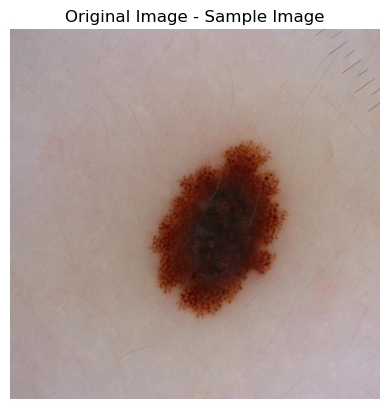

In [143]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image - Sample Image")
plt.axis('off')
plt.show()

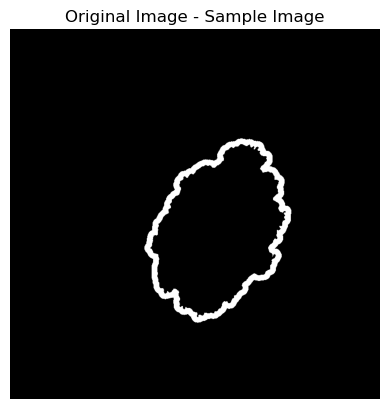

In [144]:

plt.imshow(surrounding_mask, cmap='gray')
plt.title("Original Image - Sample Image")
plt.axis('off')
plt.show()

In [128]:
thresh.shape

(1024, 1024)

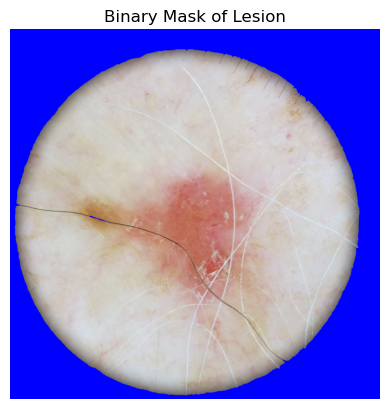

In [134]:
overlay = img_rgb.copy()
overlay[thresh == 0] = [0, 0, 255]  # Red overlay for the lesion area
plt.imshow(overlay)
# plt.imshow(thresh, cmap='gray')
plt.title("Binary Mask of Lesion")
plt.axis('off')
plt.savefig("slide2_mask.png", bbox_inches='tight')


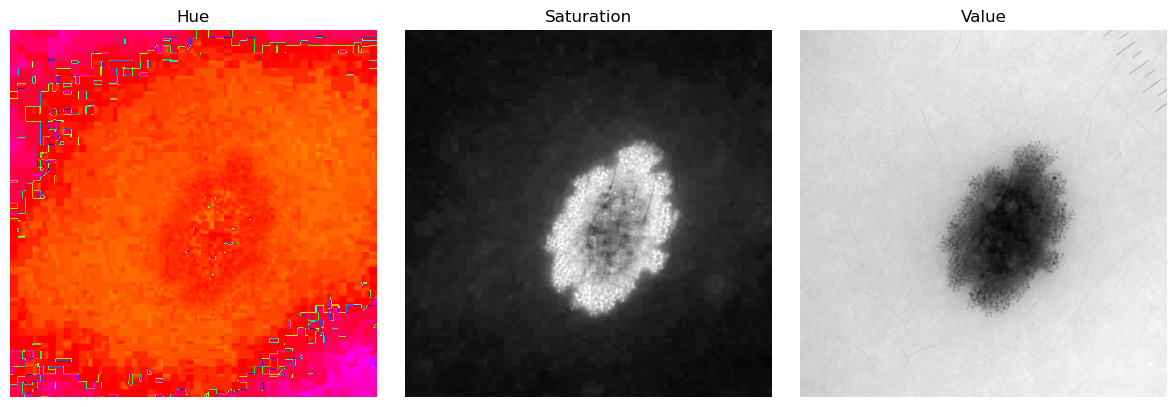

In [145]:
h, s, v = cv2.split(img_hsv)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(h, cmap='hsv'); axs[0].set_title("Hue")
axs[1].imshow(s, cmap='gray'); axs[1].set_title("Saturation")
axs[2].imshow(v, cmap='gray'); axs[2].set_title("Value")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.savefig("slide3_hsv_channels.png", bbox_inches='tight')

In [42]:
surrounding_hsv

array([], shape=(0, 3), dtype=uint8)

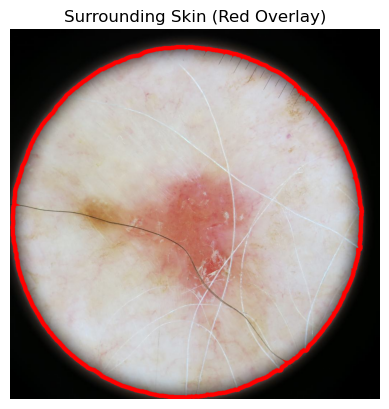

In [137]:
overlay = img_rgb.copy()
overlay[surrounding_mask == 255] = [255, 0, 0]  # Blue ring overlay
# overlay[thresh == 255] = [0, 0, 255]  # Red overlay for the lesion area
plt.imshow(overlay, cmap='hsv')
plt.title("Surrounding Skin (Red Overlay)")
plt.axis('off')
plt.savefig("slide4_surrounding_skin.png", bbox_inches='tight')

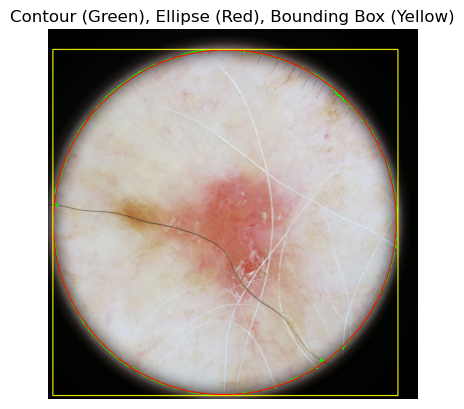

In [141]:
output = img_rgb.copy()
cv2.drawContours(output, [largest_contour], -1, (0, 255, 0), 2)  # Lesion contour

if ellipse:
    cv2.ellipse(output, ellipse, (255, 0, 0), 2)  # Fitted ellipse

x, y, w, h = cv2.boundingRect(largest_contour)
cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 0), 2)  # Bounding box

plt.imshow(output)
plt.title("Contour (Green), Ellipse (Red), Bounding Box (Yellow)")
plt.axis('off')
plt.savefig("slide5_shapes.png", bbox_inches='tight')
